导入各种库

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

借用mobilenetv3small的模型和已训练的参数
增加一个全连接层，形成一个从（224,224,3）输入到一个10个分类的输出的模型。

In [3]:
model = tf.keras.applications.MobileNetV3Small(input_shape=(224,224,3),
                                           alpha =1.0,
                                           weights = "imagenet",
                                           include_top = True,
                                           classes = 1000,
                                           #input_tensor = inputs,
                                           pooling = None,
                                           dropout_rate = 0.2,
                                           classifier_activation = "softmax",
                                           include_preprocessing = True,)
x = layers.Flatten()(model.output)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=model.inputs, outputs=outputs)

显示模型的整体结构

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

编译模型，因为是10个类，选用categorical_crossentropy 的损失配置。

In [5]:
model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics = ["accuracy"])

定义batch_size, 数据集的图片尺寸

In [6]:
#常量定义，如果输入size不同，直接可以在这里改。但是size不同，直接影响网络的设计。
#每张图片尺寸不同，这里需要更改
batch_size = 64
img_height = 224
img_width = 224

**Using `image_dataset_from_directory` to read images**
建立train_dataset 和valuation_dataset
根据你自己的数据集位置，修改data_dir 的内容。

In [7]:
data_dir = "./raw-img"

train_dataset = keras.utils.image_dataset_from_directory(
  directory=data_dir,
  labels = 'inferred',
  label_mode = 'categorical',
  #class_names = None,
  #color_mode = 'rgb',
  shuffle= True,
  validation_split=0.2,
  subset="training",
  seed=123,
  #interpolation='bilinear',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.


In [8]:
val_dataset = keras.utils.image_dataset_from_directory(
  directory=data_dir,
  labels = 'inferred',
  class_names = None,
  label_mode = 'categorical',
  #color_mode = 'rgb',
  shuffle= True,
  validation_split=0.2,
  subset="validation",
  seed=123,
  #interpolation='bilinear',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


显示数据集和label的结构

In [9]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (64, 224, 224, 3)
labels batch shape: (64, 10)


**Training **

In [10]:
epochs = 50
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

history = model.fit(
    train_dataset,
    epochs=epochs,
    initial_epoch = 0,
    validation_data=val_dataset,
    callbacks = my_callbacks)

Epoch 1/50
328/328 [==============================] - 659s 2s/step - loss: 2.2701 - accuracy: 0.1742 - val_loss: 2.2383 - val_accuracy: 0.2246
Epoch 2/50
328/328 [==============================] - 660s 2s/step - loss: 2.2257 - accuracy: 0.2158 - val_loss: 2.1989 - val_accuracy: 0.2688
Epoch 3/50
328/328 [==============================] - 660s 2s/step - loss: 2.1889 - accuracy: 0.2698 - val_loss: 2.1503 - val_accuracy: 0.3215
Epoch 4/50
328/328 [==============================] - 665s 2s/step - loss: 2.1260 - accuracy: 0.3314 - val_loss: 2.0621 - val_accuracy: 0.4090
Epoch 5/50
328/328 [==============================] - 665s 2s/step - loss: 2.0203 - accuracy: 0.4434 - val_loss: 1.9497 - val_accuracy: 0.4632
Epoch 6/50
328/328 [==============================] - 663s 2s/step - loss: 1.9045 - accuracy: 0.4718 - val_loss: 1.8397 - val_accuracy: 0.4682
Epoch 7/50
328/328 [==============================] - 664s 2s/step - loss: 1.7950 - accuracy: 0.5060 - val_loss: 1.7336 - val_accuracy: 0.5417

显示训练好的模型在valuation_dataset 上的准确性

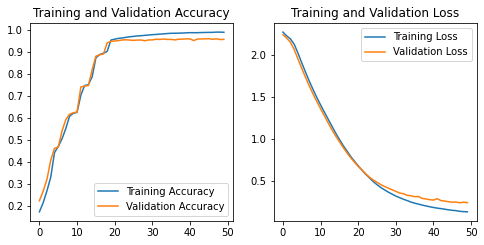

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

保存训练好的模型

In [ ]:
model.save("tenanimal.h5",
            overwrite = True,
            include_optimizer = True,
            save_format = None,
            signatures = None,
            options = None,
            save_traces = True,)

可以在命令行下将h5模型转换为tflite的模型

In [ ]:
convert h5 to tflite file
use below command

：tflite_convert --output_file=file.tflite --keras_model_file=file.h5

下一步通过GreenWaves的nntool工具，导入tflite模型，在nntool工具中进行量化，量化时需要少量的图片做量化。
所以这里需要挑几张图片，放到./imgs 文件夹下，转换成合适的size 和格式
1. 本身图片分辨率各不相同，我们转化为模型的标准输入尺寸，定义如下
img_height = 224
img_width = 224
2. Jpg格式转为ppm
3. 最后存入result文件夹中
将tflite模型和result文件夹，提供给nntool工具

In [10]:
from PIL import Image
import os.path
import glob
import os

In [11]:
os.mkdir("./result")

FileExistsError: [WinError 183] 当文件已存在时，无法创建该文件。: './result'

In [7]:
img_height = 224
img_width = 224
orignal_add = "./imgs"
result_add = "./result"

In [8]:
def jpg2ppm(jpg_file, ppm_dir):
    jpg = Image.open(jpg_file)
    jpg = jpg.resize((img_height,img_width),Image.BILINEAR)
    name = (str)(os.path.join(ppm_dir,os.path.splitext(os.path.basename(jpg_file))[0])+".ppm")
    jpg.save(name)

In [9]:
for jpg_file in glob.glob("./imgs/*.jpg"):
    jpg2ppm(jpg_file,"./result")